In [6]:
import numpy as np
import json
import re
import tensorflow as tf
import pandas as pd
import random
import spacy
nlp = spacy.load('en_core_web_sm')

In [2]:
with open('/kaggle/input/chatbots-intent-recognition-dataset/Intent.json') as f:
    intents = json.load(f)

### Data Preprocessing 

In [3]:
def preprocessing(line):
    line = re.sub(r'[^a-zA-z.?!\']', ' ', line)
    line = re.sub(r'[ ]+', ' ', line)
    return line

In [4]:
# get text and intent title from json data
inputs, targets = [], []
classes = []
intent_doc = {}

for intent in intents['intents']:
    if intent['intent'] not in classes:
        classes.append(intent['intent'])
    if intent['intent'] not in intent_doc:
        intent_doc[intent['intent']] = []
        
    for text in intent['text']:
        inputs.append(preprocessing(text))
        targets.append(intent['intent'])
        
    for response in intent['responses']:
        intent_doc[intent['intent']].append(response)

In [7]:
data=[]
for intent in intent_doc:
    for text, responses in zip(inputs, intent_doc[intent]):
        data.append({'Input': text, 'Response': responses})

# Create a DataFrame
df = pd.DataFrame(data)

In [8]:
df.head(100)

,Input,Response
0,Hi,"Hi human, please tell me your GeniSys user"
1,Hi there,"Hello human, please tell me your GeniSys user"
2,Hola,"Hola human, please tell me your GeniSys user"
3,Hi,Great! Hi <HUMAN>! How can I help?
4,Hi there,"Good! Hi <HUMAN>, how can I help you?"
...,...,...
95,Who are you talking to?,Reverend Jones said I become obsolete and then...
96,What name do you call me by?,Ross said he gave her a gift and she denied it...
97,Tell me my name,Sarah Ann Francisco said I calling his friend ...
98,What is your name?,Stefan said he meet a lot of people at school ...


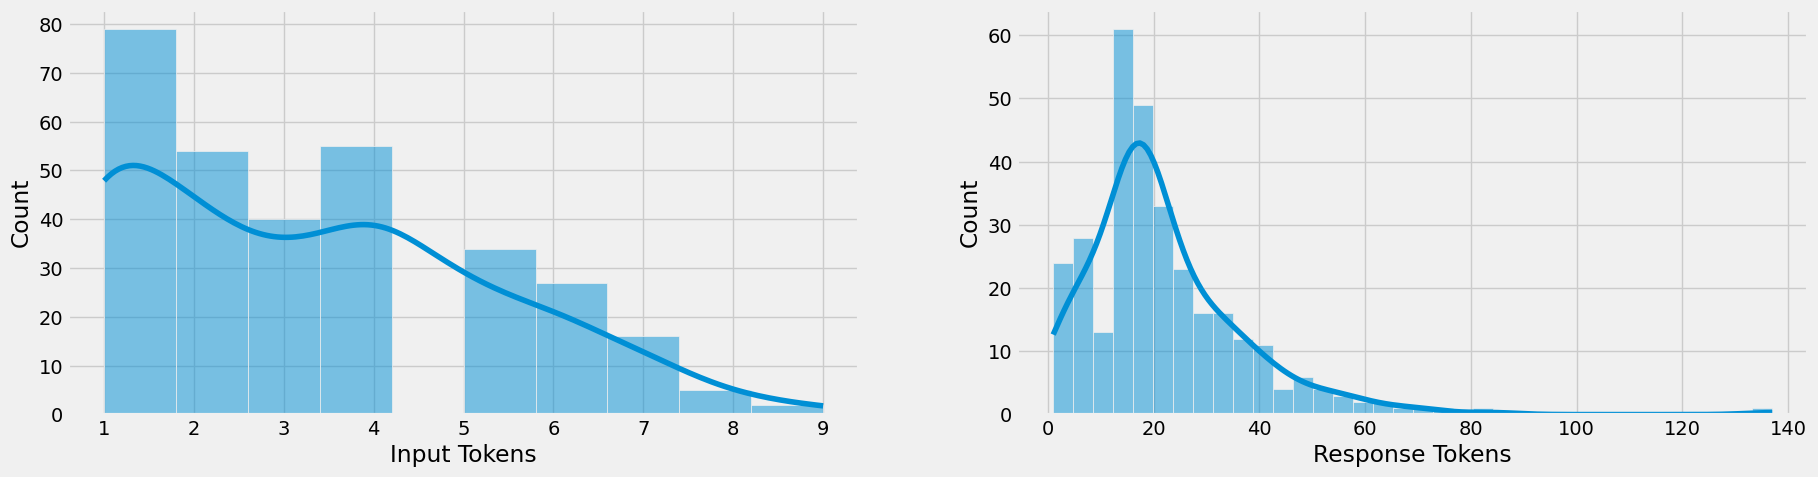

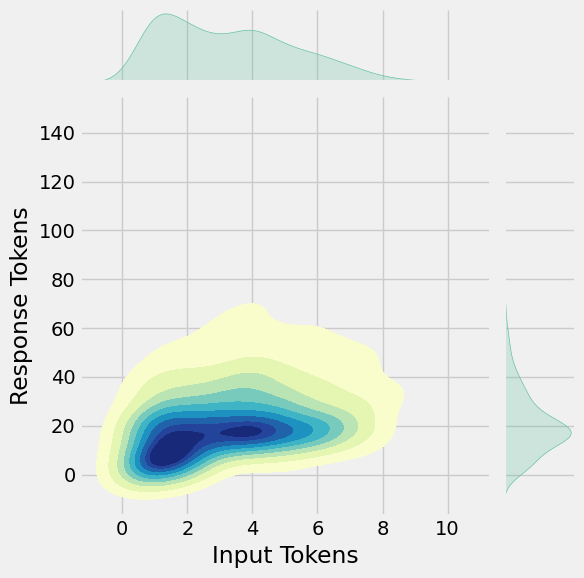

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Tokenize the input and response
df['Input Tokens'] = df['Input'].apply(lambda x: len(x.split()))
df['Response Tokens'] = df['Response'].apply(lambda x: len(x.split()))

# Set the style
plt.style.use('fivethirtyeight')

# Create subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
sns.set_palette('Set2')

# Plot histograms with KDE
sns.histplot(x=df['Input Tokens'], kde=True, ax=ax[0])
sns.histplot(x=df['Response Tokens'], kde=True, ax=ax[1])

# Create a joint plot
sns.jointplot(x='Input Tokens', y='Response Tokens', data=df, kind='kde', fill=True, cmap='YlGnBu')

plt.show()


In [10]:
def tokenize_data(input_list):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<unk>')
    
    tokenizer.fit_on_texts(input_list)
    
    input_seq = tokenizer.texts_to_sequences(input_list)

    input_seq = tf.keras.preprocessing.sequence.pad_sequences(input_seq, padding='pre')
    
    return tokenizer, input_seq

# preprocess input data
tokenizer, input_tensor = tokenize_data(inputs)

In [11]:
def create_categorical_target(targets):
    word={}
    categorical_target=[]
    counter=0
    for trg in targets:
        if trg not in word:
            word[trg]=counter
            counter+=1
        categorical_target.append(word[trg])
    
    categorical_tensor = tf.keras.utils.to_categorical(categorical_target, num_classes=len(word), dtype='int32')
    return categorical_tensor, dict((v,k) for k, v in word.items())

# preprocess output data
target_tensor, trg_index_word = create_categorical_target(targets)

In [12]:
print('input shape: {} and output shape: {}'.format(input_tensor.shape, target_tensor.shape))

input shape: (143, 9) and output shape: (143, 22)


### Build the model

In [13]:
# hyperparameters
epochs=50
vocab_size=len(tokenizer.word_index) + 1
embed_dim=512
units=128
target_length=target_tensor.shape[1]

In [14]:
# build RNN Model with tensorflow
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, embed_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units, dropout=0.2)),
    tf.keras.layers.Dense(units, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(target_length, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(lr=1e-2)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 512)         66048     
                                                                 
 bidirectional (Bidirectiona  (None, 256)              656384    
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 22)                2838      
                                                                 
Total params: 758,166
Trainable params: 758,166
Non-trainable params: 0
__________________________________________________

In [15]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)

# train the model
history=model.fit(input_tensor, target_tensor, epochs=epochs, callbacks=[early_stop])

Epoch 1/50
5/5 [==============================] - 7s 47ms/step - loss: 3.0938 - accuracy: 0.0280
Epoch 2/50
5/5 [==============================] - 0s 46ms/step - loss: 3.0560 - accuracy: 0.0909
Epoch 3/50
5/5 [==============================] - 0s 45ms/step - loss: 3.0174 - accuracy: 0.1608
Epoch 4/50
5/5 [==============================] - 0s 45ms/step - loss: 2.9748 - accuracy: 0.2098
Epoch 5/50
5/5 [==============================] - 0s 48ms/step - loss: 2.9102 - accuracy: 0.2797
Epoch 6/50
5/5 [==============================] - 0s 46ms/step - loss: 2.8020 - accuracy: 0.3007
Epoch 7/50
5/5 [==============================] - 0s 45ms/step - loss: 2.6542 - accuracy: 0.3566
Epoch 8/50
5/5 [==============================] - 0s 46ms/step - loss: 2.3861 - accuracy: 0.3776
Epoch 9/50
5/5 [==============================] - 0s 46ms/step - loss: 2.0355 - accuracy: 0.4476
Epoch 10/50
5/5 [==============================] - 0s 45ms/step - loss: 1.7613 - accuracy: 0.5315
Epoch 11/50
5/5 [============

In [16]:
def response(sentence):
    sent_seq = []
    doc = nlp(repr(sentence))
    
    # split the input sentences into words
    for token in doc:
        if token.text in tokenizer.word_index:
            sent_seq.append(tokenizer.word_index[token.text])

        # handle the unknown words error
        else:
            sent_seq.append(tokenizer.word_index['<unk>'])

    sent_seq = tf.expand_dims(sent_seq, 0)
    # predict the category of input sentences
    pred = model(sent_seq)

    pred_class = np.argmax(pred.numpy(), axis=1)
    
    # choice a random response for predicted sentence
    return random.choice(intent_doc[trg_index_word[pred_class[0]]]), trg_index_word[pred_class[0]]

# chat with bot
print("Note: Enter 'quit' to break the loop.")
while True:
    input_ = input('You: ')
    if input_.lower() == 'quit':
        break
    res, typ = response(input_)
    print('Bot: {} -- TYPE: {}'.format(res, typ))
    print()

Note: Enter 'quit' to break the loop.


You:  hi


Bot: Hello human, please tell me your GeniSys user -- TYPE: Greeting



You:  how ara you ?


Bot: Hi, I am good thank you, how are you? Please tell me your GeniSys user -- TYPE: CourtesyGreeting



You:  quit
